## Political ads on Facebook in Canada

This is the Jupyter notebook with the analysis code used forthe CBC report [What 35,000 political ads on Facebook reveal about Canada's election-year message battle](https://www.cbc.ca/news/politics/facebook-political-ads-canadian-federal-election-1.5246710)

For a description of data columns, see the README.

The entire notebook uses the following libraries:
* pandas
* numpy
* nltk
* scikit-learn
* wordcloud

These can all be install with pip

Import main libraries and set display options

In [2]:
import pandas as pd
import numpy as np

pd.options.display.max_colwidth = 250
%matplotlib inline

Load data files

In [43]:
df = pd.read_csv('data/fb_ads_main.csv', sep=',', escapechar = '\\', encoding = 'utf-8')

df[['ad_creation_time', 'ad_delivery_start_time']] = df[['ad_creation_time', 'ad_delivery_start_time']].apply(pd.to_datetime)
if 'ad_delivery_stop_time' in df.columns:
    df.ad_delivery_stop_time = pd.to_datetime(df.ad_delivery_stop_time)
    
# Calculate median of impression and ad spend ranges to get a more realistic estimate
df['spend_median'] = df[['spend_lower_bound', 'spend_upper_bound']].apply(np.median, axis = 1)
df['impressions_median'] = df[['impressions_lower_bound', 'impressions_upper_bound']].apply(np.median, axis = 1)
    
demo = pd.read_csv('data/fb_ads_demographics.csv', encoding = 'utf-8').set_index('ad_id')
geo = pd.read_csv('data/fb_ads_geography.csv', encoding = 'utf-8').set_index('ad_id')

df.head()

C:\Users\Beto\AppData\Local\Continuum\miniconda3\envs\data\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


,ad_creation_time,ad_creative_body,ad_creative_link_caption,ad_creative_link_description,ad_delivery_start_time,ad_delivery_stop_time,currency,funding_entity,impressions_lower_bound,impressions_upper_bound,page_id,page_name,spend_lower_bound,ad_id,spend_upper_bound,scrape_date,spend_median,impressions_median
0,2019-08-09 15:30:55+00:00,Discover the impact pipelines have on your life today and in the future...,sharedfuture.ca/economy,See all sides. Sharedfuture.ca,2019-08-09 15:30:55+00:00,2019-12-14 06:59:00+00:00,CAD,Canadian Energy Pipeline Association,0.0,999.0,230258673663722,CEPA - about pipelines,0.0,221641715404183,99.0,2019-08-12,49.5,499.5
1,2019-08-09 15:30:55+00:00,"Do all provinces benefit from pipelines? Yes, they move $billions into ...",sharedfuture.ca/economy,You might be surprised to discover just how important oil and natural g...,2019-08-09 15:30:55+00:00,2019-12-14 06:59:00+00:00,CAD,Canadian Energy Pipeline Association,0.0,999.0,230258673663722,CEPA - about pipelines,0.0,355145235409947,99.0,2019-08-12,49.5,499.5
2,2019-08-09 15:30:55+00:00,Canada’s energy future benefits all provinces and territories.,sharedfuture.ca/economy,The energy future is a balanced future. Sharedfuture.ca,2019-08-09 15:30:55+00:00,2019-12-14 06:59:00+00:00,CAD,Canadian Energy Pipeline Association,0.0,999.0,230258673663722,CEPA - about pipelines,0.0,416363292314883,99.0,2019-08-12,49.5,499.5
3,2019-08-09 15:30:55+00:00,Oil and natural gas contribute $billions to fund vital government socia...,sharedfuture.ca/economy,Wonder how oil and natural gas benefit every single province?,2019-08-09 15:30:55+00:00,2019-12-14 06:59:00+00:00,CAD,Canadian Energy Pipeline Association,0.0,999.0,230258673663722,CEPA - about pipelines,0.0,422723455120065,99.0,2019-08-12,49.5,499.5
4,2019-08-09 15:30:55+00:00,"Do all provinces benefit from pipelines? Yes, they move $billions into ...",sharedfuture.ca/economy,You might be surprised to discover just how important oil and natural g...,2019-08-09 15:30:55+00:00,2019-12-14 06:59:00+00:00,CAD,Canadian Energy Pipeline Association,0.0,999.0,230258673663722,CEPA - about pipelines,0.0,454310915422717,99.0,2019-08-12,49.5,499.5


Number of ads in data

In [44]:
len(df)

36952

Number of advertisers

In [45]:
len(df["page_id"].unique())

2914

Number of ads per month

C:\Users\Beto\AppData\Local\Continuum\miniconda3\envs\data\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


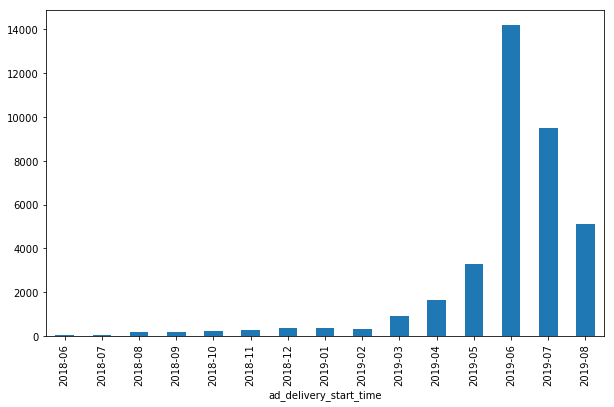

In [46]:
df.groupby(df.ad_delivery_start_time.dt.to_period('M')).size().loc['2018-06' : ].plot.bar(figsize = (10,6))

In [47]:
# Pages with most ads
df.page_name.value_counts().head(30)

Plan International Canada                                      2053
CEPA - about pipelines                                         1697
Liberal Party of Canada | Parti libéral du Canada              1146
Justin Trudeau                                                  970
North99                                                         843
Tommy Gun's Original Barbershop                                 811
Joyful Earth                                                    704
Dying With Dignity Canada                                       594
Canadian Taxpayers Federation                                   550
Fair Path Forward                                               503
Wholesome Culture                                               453
Save Elephants                                                  439
Lufa Farms                                                      413
Curiated                                                        380
Conservative Party of Canada - Parti conservateu

In [48]:
# Exclude the obvious non-political pages from the top advertisers

nonpoli = ["Tommy Gun's Original Barbershop", 'Lufa Farms', 'Curiated', 'PoseFlex', 'KauseShop', 'Pela Case',
           'Joyful Earth', 'TreeHouse Supply', 'Loup de Remise', 'Tru Earth', 'Your Moon Time',
          'LiquidationChrysler.com', 'Les Fermes Lufa', 'АТОН', 'Zqbuy.shop', 'Share Lawyers',
          "Maraya's Marketplace", 'Kiniyo', 'Janet Hunter', 'Yoyitg', 'Earthsider', 
          'Fifth Avenue Real Estate Marketing', 'Anti-Mosquito', 'Diego Dreyfus', 'Home utensil',
          'Manchester Metropolitan University Business School', 'Awesome Tees: Funny', 'Lunapads',
          'I Love Cycling', 'New Wave Swim Buoy', 'The Anti Cellulite', 'Freshhiss', 'Maison Bureau & Bureau, Meubles Déco Électro',
          "Lori and Dan's Adventures", 'Sweet Case', 'Gift Haven', 'Canadian Money Link', 'Beeyond Smart Security', 'Honey Birdette',
          'noissue.co', 'Flashfood App', "Champion's Creed MMA", 'TruGreen Energy', 'FancyKey Keyboard', 'Hugofireshop.com',
          'TD', 'göt2b Canada', 'Corona Canada']

len(nonpoli)

48

Create new dataframe without those advertisers

In [49]:
ads = df[~df.page_name.isin(nonpoli)]
len(ads)

30289

Load Facebook's [ad library report](https://www.facebook.com/ads/library/report/) to get precise ad spend numbers

In [50]:
# Compare fetched API ads to ad library report counts

report = pd.read_csv('FacebookAdLibraryReport_2019-08-10_CA_lifelong_advertisers.csv', dtype={'Page ID' : str})
report.columns = ['page_id', 'page_name', 'disclaimer','amount_spent', 'num_ads']
report['amount_spent'] = report['amount_spent'].str.replace('≤', '').astype(int)
print('Number of ads in library report:')
report['num_ads'].sum()

Number of ads in library report:


27230

Pages that spent the most according to the report

In [75]:
report.groupby('page_name').amount_spent.sum().sort_values(ascending = False).head(25)

page_name
Shaping Canada's Future                                        188223
Corona Canada                                                  145461
Unifor Canada                                                  133267
Plan International Canada                                      119548
Liberal Party of Canada | Parti libéral du Canada              102404
Conservative Party of Canada - Parti conservateur du Canada    101810
CEPA - about pipelines                                          88070
Engage Canada                                                   72552
UNHCR Canada                                                    63595
Nature Canada                                                   55285
TD                                                              52608
göt2b Canada                                                    51812
Justin Trudeau                                                  50106
Elections Canada                                                46162
Ontario Se

Number of ads per page that didn't mention a funding entity in all time rage

In [114]:
ads[ads.funding_entity == ''].page_name.value_counts().head(30)

North99                                                        633
Canadian Taxpayers Federation                                  542
CEPA - about pipelines                                         540
Plan International Canada                                      512
Save Elephants                                                 439
Canadian Association of Petroleum Producers (CAPP)             343
Wholesome Culture                                              279
Liberal Party of Canada | Parti libéral du Canada              238
Voices for Refugees - أصوات لأجل اللاجئين                      236
Alberta Taxpayers                                              215
OECTA - Ontario English Catholic Teachers Association          142
Open Society Foundations                                       137
Education is Worth It                                          125
Justin Trudeau                                                 124
Ontario Secondary School Teachers' Federation (OSSTF)         

Now those in the re-writ period, when the new rules were in force

In [57]:
ads[(ads.funding_entity.isna()) & (ads.ad_delivery_start_time >= '2019-06-29')].page_name.value_counts().head(20)

Gud Nature                            44
CUPE Manitoba                         39
Wholesome Culture                     36
Angus Reid Forum/ Forum Angus Reid    31
Plant Powered                         27
Seestainable                          22
Wild First                            20
Workable Campaigns                    19
Amazingecostraw                       19
My Last Straw                         17
The Fraser Institute                  15
Rockwell Razors                       14
Naco's Shops                          14
BustedTees.com                        12
University of Sussex                  12
Farmway Foods                         12
Lucas Seaward                         11
Canadian Badlands                     11
SEPHORA                               11
Skiis & Biikes                        11
Name: page_name, dtype: int64

Pages that paid in non CAD currency and had high impressions in Canada

In [58]:
non_cad_pages = ads[(ads.currency != 'CAD')
                   & (ads.impressions_median > 10000)]

(non_cad_pages.groupby(['currency', 'page_name'])
 .size()
 .reset_index(name = 'ads')
 .sort_values(['currency', 'ads'], ascending = [1,0])
 .groupby('currency').head(5)
)

,currency,page_name,ads
0,AED,WWICS Global,1
1,ARS,Treevotion,2
18,AUD,World Transformation Movement,23
5,AUD,Deliciou,9
8,AUD,Fitness Engineering,8
3,AUD,Biome Eco Stores,6
7,AUD,Eleutheromania,5
23,BRL,QuintoAndar,2
21,BRL,Benitez,1
22,BRL,Fabio Vido ilustrador,1


Take a closer look at some of them

In [59]:
selected_non_cad_pages = ["UNICEF Canada",
"Je suis fier d'être Québécois",
"FR.DatingAdvisor CA",
"Parti Vert du Canada - Québec / Chaudière-Appalaches",
"La chronique d'un citoyen du Québec",
'Capitalism For Canada',
'Independent Contractors and Businesses Association of BC',
'Canadian Association for Equality',
'New Brunswick Proud',
'Indigenous Women of the Americas Defending Mother Earth Treaty',
"Comité d'action solidaire contre l'austerité - CASA",
'WWF-Canada',
'Liberal Party of Canada in Nanaimo-Ladysmith'
'Safe Haven For Donkeys In The Holy Land- USA & Canada',
"People's Party of Canada - Eglinton Lawrence",
'Brian Chamberlain - Seeks Nomination for Aurora, Oak Ridges, Richmond Hill',
'John Couture for Cape Breton Canso',
'Canada Life Co',
'Barcelos Flame Grilled Chicken Canada',
'Maru Voice Canada',
'Access Canada',
'Human Resources Director Canada',
'Samuel Moisan-Domm - Parti vert du Canada',
'rabble.ca',
'Ontario SPCA Friends For Life Walk']

(ads.query('page_name in @selected_non_cad_pages')[['page_name', 'currency', 'ad_creative_body']]
  .groupby(['page_name', 'currency'])
  .size()
  .reset_index(name='ads')
  .sort_values(['currency', 'ads'], ascending = [0, 0])
).head(20)

,page_name,currency,ads
26,UNICEF Canada,USD,97
13,Je suis fier d'être Québécois,USD,43
22,Parti Vert du Canada - Québec / Chaudière-Appalaches,USD,28
28,WWF-Canada,USD,24
17,Maru Voice Canada,USD,19
25,Samuel Moisan-Domm - Parti vert du Canada,USD,11
23,People's Party of Canada - Eglinton Lawrence,USD,4
6,Capitalism For Canada,USD,3
29,rabble.ca,USD,3
16,La chronique d'un citoyen du Québec,USD,2


Pages that advertised less in July vs. June, after the new rules were enacted

In [65]:
junjul = (ads.groupby(['page_name', ads.ad_delivery_start_time.dt.to_period('M').astype(str)])
          .size()
          .loc[slice(None), slice('2019-06', '2019-07')]
          .unstack()
         )
          
junjul = junjul.assign(change = (junjul['2019-07'] - junjul['2019-06']) / junjul['2019-06']).sort_values('change')

junjul[(junjul['2019-06'] >= 10) & (junjul.change < 0)]

ad_delivery_start_time,2019-06,2019-07,change
page_name,,,
Canadian Taxpayers Federation,330.0,1.0,-0.996970
Stand.earth,36.0,1.0,-0.972222
WWF-Canada,23.0,1.0,-0.956522
مفوضية اللاجئين,114.0,5.0,-0.956140
LiveNami,21.0,1.0,-0.952381
PatPat,20.0,1.0,-0.950000
eMastered,18.0,1.0,-0.944444
International Rescue Committee,16.0,1.0,-0.937500
Bio-Straw,26.0,2.0,-0.923077


Most expensive ads in CAD

In [50]:
cad = ads.query('currency == "CAD"')

cad.sort_values('spend_median', ascending=False)[['ad_creation_time', 'ad_delivery_start_time', 'page_name', 'spend_median', 'ad_creative_body']].head(20)

,ad_creation_time,ad_delivery_start_time,page_name,spend_median,ad_creative_body
25124,2019-07-05 21:31:53+00:00,2019-07-08 18:00:23+00:00,Unifor Canada,74999.5,"This election, stand strong and demand a real plan for new jobs."
424,2019-08-06 18:09:23+00:00,2019-08-06 18:09:23+00:00,RBC,29999.5,The debit card designed to shop online. Pay from your bank account and have peace of mind.
25186,2019-06-07 22:26:52+00:00,2019-06-10 18:00:24+00:00,Unifor Canada,29999.5,"This election, stand strong and demand a real plan for new jobs."
20566,2019-05-28 03:40:31+00:00,2019-05-28 03:40:31+00:00,Engage Canada,29999.5,Andrew Scheer: Yes man to the 1%. His weakness will cost you. #ScheerWeakness
7740,2019-06-19 14:23:13+00:00,2019-06-19 14:23:13+00:00,Shaping Canada's Future,29999.5,NaN
8259,2019-05-10 02:22:25+00:00,2019-05-10 02:22:25+00:00,Conservative Party of Canada - Parti conservateur du Canada,29999.5,Justin Trudeau n'est pas celui qu’il prétendait être.\n\nEngagez-vous à le destituer de ses fonctions en octobre prochain en signant ci-dessous : https://www.conservateur.ca/cpc/pas-celui-quil-pretendait-etre/
7681,2019-06-19 14:23:13+00:00,2019-06-19 14:23:13+00:00,Shaping Canada's Future,29999.5,NaN
22327,2019-06-18 20:18:40+00:00,2019-06-18 20:18:40+00:00,Liberal Party of Canada | Parti libéral du Canada,29999.5,"On se tient debout. Pour vous. \n\nPour en savoir plus, visitez le www.liberal.ca."
7749,2019-06-19 14:23:13+00:00,2019-06-19 14:23:13+00:00,Shaping Canada's Future,29999.5,NaN
25143,2019-07-05 21:31:53+00:00,2019-07-08 18:00:23+00:00,Unifor Canada,29999.5,"This election, stand strong and demand a real plan for new jobs."


Number of ads per advertisers that cost at least $1000

In [40]:
cad.query('spend_lower_bound >= 1000').page_name.value_counts().head(18)

Shaping Canada's Future                                        44
Ontario Secondary School Teachers' Federation (OSSTF)          31
Pela Case                                                      30
Conservative Party of Canada - Parti conservateur du Canada    28
Liberal Party of Canada | Parti libéral du Canada              25
Plan International Canada                                      19
Corona Canada                                                  17
UNHCR Canada                                                   15
Canadian Association of Petroleum Producers (CAPP)             14
Unifor Canada                                                  13
CEPA - about pipelines                                         11
Oceana Canada                                                  10
TREB                                                           10
Engage Canada                                                  10
Save the Children Canada                                       10
Canada Pro

Advertisers that targeted provinces: this assumes that ad ad that had at least 95% of impressions in a single province was region-targeted

In [51]:
(geo[geo.percentage >= 0.95]
  .merge(ads, on='ad_id')
  .groupby(['region', 'page_name'])
  .spend_median.agg(['count', 'sum'])
  .sort_values(['region', 'count'], ascending = [1, 0])
  .groupby('region')
  .head(10)
  .assign(rank = lambda x: x.groupby('region')['count'].rank('first', ascending=False))
)

count  \
region           page_name                                                            
Alberta          Alberta Taxpayers                                              330   
                 Dying With Dignity Canada                                      249   
                 JWN                                                             63   
                 United Conservative Party of Alberta                            56   
                 ATCOenergy                                                      44   
                 WestWatch Canada                                                32   
                 Angus Reid Forum/ Forum Angus Reid                              29   
                 Kent Hehr                                                       25   
                 Scrubbi                                                         25   
                 Justin Trudeau                                                  23   
British Columbia CEPA - about pipelines                                         288   
                 Wild First                                                     119   
                 BC Liberal Party                                                89   
                 Byron Horner for Courtenay-Alberni                              80   
                 Bridget Burns                                                   62   
                 John Yap                                                        50   
                 Gord Johns: Courtenay-Alberni Member of Parliament              47   
                 Rob Morrison For MP                                             35   
                 Tom Shypitka                                                    31   
                 Nature Canada                                                   28   
Manitoba         CUPE Manitoba                                                   60   
                 UFCW Local 832                                                  50   
                 PC Party of Manitoba                                            45   
                 Manitoba Nurses Union                                           39   
                 Justin Trudeau                                                  26   
                 Liberal Party of Canada | Parti libéral du Canada               23   
                 Conservative Party of Canada - Parti conservateur du Canada     22   
                 Manitoba Federation of Labour                                   20   
                 Keeping Liquor Public                                           15   
                 Kevin Lamoureux                                                 14   
...                                                                             ...   
Quebec           Parti Vert du Canada - Québec / Chaudière-Appalaches            77   
                 Liberal Party of Canada | Parti libéral du Canada               73   
                 Greenpeace Canada                                               63   
                 Samuel Moisan-Domm - Parti vert du Canada                       54   
                 Fédération canadienne des contribuables                         51   
                 Unpointcinq                                                     49   
                 Conservative Party of Canada - Parti conservateur du Canada     46   
                 Société pour la nature et les parcs - SNAP Québec               43   
                 Je suis fier d'être Québécois                                   41   
                 Justin Trudeau                                                  34   
Saskatchewan     Saskatchewan Party                                              28   
                 WestWatch Canada                                                28   
                 Justin Trudeau                                                  27   
                 Liberal Party of Canada | Parti libéral du Canada          

The biggest ad campaigns. A campaign is assumed to be multiple ads with the same text.

In [52]:
(ads.groupby(['page_name', 'ad_creative_body'])
 .spend_median
 .agg(['count', 'sum'])
 .reset_index()
 .sort_values('count', ascending = False)
 .head(25)
)

,page_name,ad_creative_body,count,sum
1979,Dying With Dignity Canada,Assisted dying is a right in Canada – yet many Alberta hospitals refuse to provide access to it. Premier Kenney must stand up for patients' rights!,159,7870.5
5272,Plan International Canada,6 million children die every year from preventable diseases. What if you could help make a difference by just signing your name?,137,6781.5
4783,North99,"BREAKING: Canada’s public health care is at risk.\n\nWith Kenney's victory in Alberta, Ford's radical healthcare overhaul and Scheer leading in the polls, we need to act - we've launched an Emergency Petition to hit 10,000 signatures by the end o...",131,12334.5
5275,Plan International Canada,830 women and girls die every day due to pregnancy complications. Sign your name to #ChangetheBirthStory.,129,6385.5
5290,Plan International Canada,"For many mother's across the world, it's normal to give birth without access to essential health care. You can #DefyNormal by simply signing your name.",127,6286.5
5313,Plan International Canada,Normal is 830 women and girls dying every day due to pregnancy complications. Help create a new normal where women have better access to health care. Sign your name to help #ChangeTheBirthstory.,126,6237.0
5267,Plan International Canada,"1 woman dies every 2 minutes from birth related complications, leading to approximately 830 deaths every day. Sign your name to help #ChangeTheBirthStory and #DefyNormal.",107,6046.5
5281,Plan International Canada,"By encouraging men to support their families' health, rights and well-being, we can help create a new normal. Sign our pledge of support to help #ChangeTheBirthstory.",106,11097.0
1980,Dying With Dignity Canada,"In Canada, the right to medical assistance in dying is protected by law. \n\nHowever, that right has remained out of reach for many suffering people on the basis of their diagnoses. Canada’s assisted dying law forbids them from making an end-of-l...",105,5197.5
5799,Save Elephants,This shirt is not sold in stores and is only available for a short time.\nOrder here: => https://www.singtee.com/elephants-1g\nSee more at our site => https://www.singtee.com/stores/elephants,104,12648.0


### NLP section. This uses the nltk library to do word frequency counts

In [25]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Load stopword lists for English amd French
stop_eng = stopwords.words('english')
stop_fra = stopwords.words('french')
stop_fra.extend('les ça cest cette si'.split())

# Create column with normalized tokens
text = (ads.ad_creative_body
        .fillna('')
        .str.lower()
        .str.replace('[^\w\s]','')
        .apply(lambda x:  ' '.join([word for word in x.split() if pd.notna(x) and word not in stop_eng and word not in stop_fra]))
        .apply(word_tokenize)
       )
ads['tokens'] = text

C:\Users\Beto\AppData\Local\Continuum\miniconda3\envs\data\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Most frequent words overall


In [26]:
from collections import Counter

all_tokens = [a for b in ads.tokens.tolist() for a in b]
Counter(all_tokens).most_common(50)

[('help', 5489),
 ('get', 4887),
 ('canada', 4117),
 ('us', 3459),
 ('support', 3077),
 ('today', 2933),
 ('time', 2907),
 ('make', 2766),
 ('need', 2735),
 ('new', 2705),
 ('free', 2668),
 ('health', 2494),
 ('see', 2441),
 ('people', 2425),
 ('every', 2327),
 ('sign', 2301),
 ('like', 2235),
 ('world', 2191),
 ('name', 2065),
 ('day', 2006),
 ('change', 1996),
 ('one', 1913),
 ('better', 1906),
 ('canadians', 1841),
 ('future', 1800),
 ('education', 1782),
 ('save', 1720),
 ('way', 1713),
 ('energy', 1703),
 ('care', 1695),
 ('government', 1684),
 ('shipping', 1640),
 ('work', 1631),
 ('climate', 1609),
 ('go', 1576),
 ('right', 1576),
 ('want', 1547),
 ('girls', 1546),
 ('join', 1530),
 ('pipelines', 1511),
 ('take', 1460),
 ('many', 1459),
 ('use', 1457),
 ('life', 1446),
 ('1', 1446),
 ('year', 1418),
 ('normal', 1411),
 ('rights', 1410),
 ('made', 1396),
 ('dont', 1385)]

Make a pretty word cloud with with the most frequent words overall

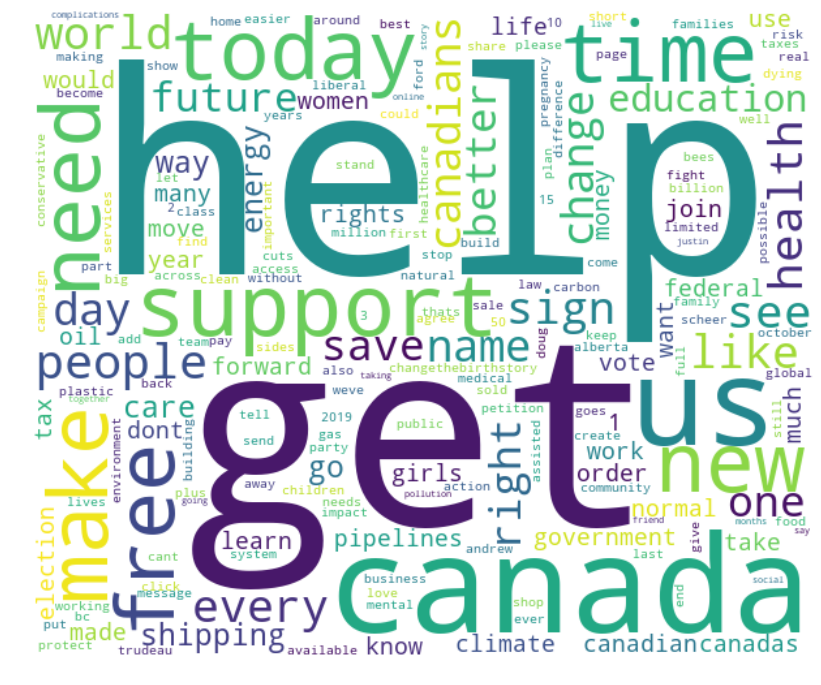

In [40]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(background_color="white", margin=2, width= 600, height = 500).generate_from_frequencies( dict(Counter(all_tokens).most_common(200)))
plt.figure(figsize=(14,12))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('fabebook_ads_words.svg')

Most frequent bigrams: two words that go together a lot. This uses the scikit-learn library

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a column with the joined tokens as a single string
ads['tokens_str'] = ads.tokens.apply(lambda x: ' '.join(x))

word_vectorizer = CountVectorizer(ngram_range=(1,2), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(ads.tokens_str)
frequencies = sum(sparse_matrix).toarray()[0]
ngrams = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency']).sort_values('frequency', ascending = False)

C:\Users\Beto\AppData\Local\Continuum\miniconda3\envs\data\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [32]:
ngrams[ngrams.index.str.contains(' ')].head(20)

,frequency
climate change,1146
health care,1072
sign name,1028
move forward,999
free shipping,978
forward see,957
easier move,957
carbon tax,805
help changethebirthstory,748
see sides,718


Most common words in region-targeted ads


In [33]:
province_words = pd.DataFrame(columns = sorted(geo.region.unique()))

# Get all ad IDs shown to provinces that had at least 75% of all impressions
province_ads = geo[geo.percentage > 0.95].groupby('region').apply(lambda x: x.to_dict(orient = 'split'))
for province, ad_ids in province_ads.iteritems():
    prov_ad_tokens = [a for b in ads[ads.ad_id.isin(ad_ids['index'])].tokens.to_list() for a in b]
    prov_counts = Counter(prov_ad_tokens).most_common(15)
    province_words[province] = [word[0] for word in prov_counts]
    
province_words

,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
0,pipelines,bc,union,vote,energy,women,new,recycling,education,vote,plus,saskatchewan,yukon
1,equalization,see,vote,october,vote,health,nova,facebook,ford,great,québec,vote,whitehorse
2,alberta,canada,deserve,canadians,october,minister,vote,page,climate,armstrong,canada,government,vote
3,patients,energy,better,liberal,education,government,solar,nunavut,us,october,mouvement,dodge,party
4,assisted,move,fight,fight,children,support,liberal,photo,need,charlottetown,maintenant,us,canada
5,canada,government,work,new,newfoundland,leadership,climate,arctic,carbon,government,vert,new,october
6,hospitals,new,manitoba,andrew,liberal,help,scotia,like,cuts,fight,faire,trudeau,community
7,join,forward,get,scheer,st,refugee,dairy,part,canada,liberal,joignezvous,support,green
8,right,like,care,justin,ride,need,help,pilot,time,egmont,tous,people,time
9,oil,get,workers,together,see,conditions,cancer,project,doug,people,québécois,goodale,local


Word frequencies of selected political pages to see how much they influence regional results

In [35]:
selected = ['Plan International Canada',
'CEPA - about pipelines',
'Liberal Party of Canada | Parti libéral du Canada',
'North99',
'Justin Trudeau',
'Canadian Taxpayers Federation',
'Conservative Party of Canada - Parti conservateur du Canada',
'Alberta Taxpayers',
'Dying With Dignity Canada',
'Voices for Refugees - أصوات لأجل اللاجئين',
'Nature Canada',
'Elementary Educators',
"Ontario Secondary School Teachers' Federation (OSSTF)",
'Save the Children Canada',
'End Stigma - Centre for Addiction and Mental Health (CAMH) Foundation',
'Canadian Association of Petroleum Producers (CAPP)',
'UNHCR Canada',
'Greenpeace Canada',
'Open Society Foundations',
'Fair Path Forward',
'Wild First',
'OECTA - Ontario English Catholic Teachers Association',
'UNICEF Canada',
'Janet Hunter',
'BC Liberal Party',
'Élections Canada',
'Mike Morrice for Kitchener Centre',
'Manchester Metropolitan University Business School',
'Parti Vert du Canada - Québec / Chaudière-Appalaches',
'Logan MP 2019',
'Elections Canada',
'Clean Energy Canada',
"Dog Owner's Association",
'Freshhiss',
'Tru Earth',
'Education is Worth It',
'Canadian Money Link',
'Ontario PC Party',
'CARE Canada',
"Shaping Canada's Future",
'World Transformation Movement',
'See the logic',
'Byron Horner for Courtenay-Alberni',
'Better Schools, Stronger Economy - Ontario',
'TruGreen Energy',
'The Fraser Institute',
'Suicide Prevention Awareness',
'Earth Rangers',
'Fédération canadienne des contribuables',
'Save The Bees',
'PlanetGreen',
'UFCW Local 832',
'Mighty Party',
'Samuel Moisan-Domm - Parti vert du Canada',
'Autism Parenting Magazine']

In [41]:
from collections import Counter
pd.options.display.max_colwidth = 75

top_n_pages = ads.page_name.value_counts().head(100).index

word_freqs_per_page = ads.groupby('page_name').agg({'tokens' : 'sum'})
word_freqs_per_page = word_freqs_per_page[word_freqs_per_page.tokens.str.len() >= 600]
word_freqs_per_page['counts'] = word_freqs_per_page.tokens.apply(lambda x: Counter(x).most_common(10))

word_freqs_per_page.loc[selected].counts

C:\Users\Beto\AppData\Local\Continuum\miniconda3\envs\data\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  # Remove the CWD from sys.path while we load stuff.


page_name
Plan International Canada                                                [(help, 1926), (normal, 1389), (name, 1365), (girls, 1331), (sign, 1200...
CEPA - about pipelines                                                   [(move, 1212), (energy, 1016), (easier, 957), (forward, 957), (see, 957...
Liberal Party of Canada | Parti libéral du Canada                        [(better, 370), (election, 343), (canadians, 309), (liberal, 269), (fut...
North99                                                                  [(health, 508), (breaking, 494), (need, 482), (ford, 466), (care, 465),...
Justin Trudeau                                                           [(canada, 365), (canadians, 357), (better, 329), (support, 308), (middl...
Canadian Taxpayers Federation                                            [(oil, 465), (get, 378), (tax, 342), (canadian, 327), (canadians, 283),...
Conservative Party of Canada - Parti conservateur du Canada              [(vote, 272), (andrew, 257), 